In [ ]:
!git clone https://github.com/WaShindeiru/IceCubeNeutrino

In [ ]:
!cp IceCubeNeutrino/* .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip ./drive/MyDrive/icecube/ice_cube_small.zip

In [1]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from Resnet import resnet34

In [2]:
sensor = pd.read_csv('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
train_meta = pq.ParquetFile('/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet')
it = train_meta.iter_batches()
train_meta = next(it).to_pandas()

In [3]:
train_meta.head(20)

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
5,1,77,352,401,0.011372,1.295371
6,1,79,402,717,3.533397,2.479947
7,1,82,718,762,5.252108,0.672366
8,1,121,763,803,3.084929,2.065880
9,1,127,804,846,6.154335,1.371721


In [4]:
sensor.head(20)

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
5,5,-256.14,-521.08,410.93
6,6,-256.14,-521.08,393.91
7,7,-256.14,-521.08,376.88
8,8,-256.14,-521.08,359.86
9,9,-256.14,-521.08,342.84


In [5]:
import torch.nn as nn
model = resnet34(pretrained = False)
model.fc = nn.Sequential(nn.ReLU(),nn.Linear(in_features=512, out_features=2))

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float).to(device)
    actual = torch.tensor([], dtype=torch.float).to(device)
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data['input_tensor'].float().to(device),data['label'].to(device)
            outputs = model(inputs).to(device)
            predictions = torch.cat((predictions, torch.stack([torch.argmax(o) for o in outputs])),0)
            actual = torch.cat((actual, values), 0)
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

In [7]:
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'


pqfile = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train_meta.parquet'
path_batch = '/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/train/'
geometry = "/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice/sensor_geometry.csv"

batch_num=8
val_batch_num=9

# lr = 1e-06
lr = 1e-07
num_epochs = 1
batch_size = 4

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss_function = nn.MSELoss().to(device)
loss_function = nn.L1Loss(reduction='mean').to(device)

In [8]:
from torch.utils.data import DataLoader
from Icecube_Dataloader import IceCube_Dataloader, collate_fn

ice_dataset = IceCube_Dataloader(pqfile, path_batch, geometry, batch_num)
train_dataset = ice_dataset

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=11)

val_dataset = IceCube_Dataloader(pqfile, path_batch, geometry, val_batch_num)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=11)

In [9]:
ice_dataset.__getitem__(0)['input_tensor'].shape

torch.Size([5, 1, 67])

In [10]:
print(device)

cuda


In [11]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'val_dataloader': val_dataloader,
    'device':device,
    'num_epoch' : num_epochs
}


In [12]:
import gc
train_losses = []
val_losses = []
outputs_ = []
accum_iter = 1

def train(model, params):
    model.train()
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    val_dataloader=params["val_dataloader"]
    val_iter = iter(val_dataloader)

    aa = 0

    device=params["device"]
    for epoch in range(0, num_epochs):
        for dat in tqdm(train_dataloader):
            # train step
            model.train()
            inputs, labels = dat['input_tensor'].to(device),dat['label'].to(device)

            assert not torch.isnan(inputs).any(), "Inputs contain NaNs"
            assert not torch.isnan(labels).any(), "Labels contain NaNs"

            outputs = model(inputs).to(device)
            outputs_.append(outputs.cpu().detach().numpy())

            train_loss = loss_function(outputs.float(),labels.float())
            train_losses.append(train_loss.item())


            # if aa%100==0:
            #     print(f"Train loss: {train_loss.item()}")

            train_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

            # validation step
            model.eval()

            with torch.no_grad():
                try:
                    temp = next(val_iter)
                    val_input = temp['input_tensor'].to(device)
                    val_label = temp['label'].to(device)
                    val_outputs = model(val_input).to(device)
                    val_loss = loss_function(val_outputs.float(),val_label.float())
                    val_losses.append(val_loss.item())
                except StopIteration:
                    pass

            aa = aa+1

    model.eval()
    gc.collect()

    torch.cuda.empty_cache()
    return 0


train(model, params)

100%|██████████| 50000/50000 [1:30:09<00:00,  9.24it/s]


0

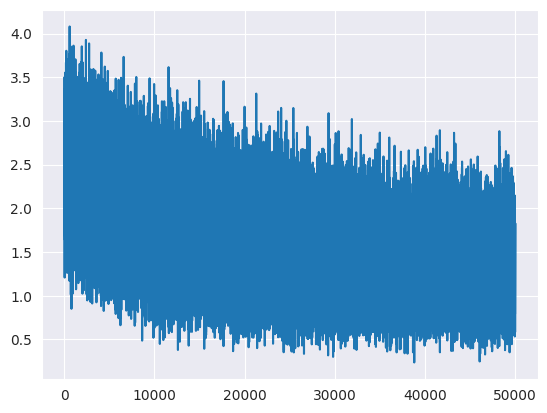

In [13]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(train_losses)

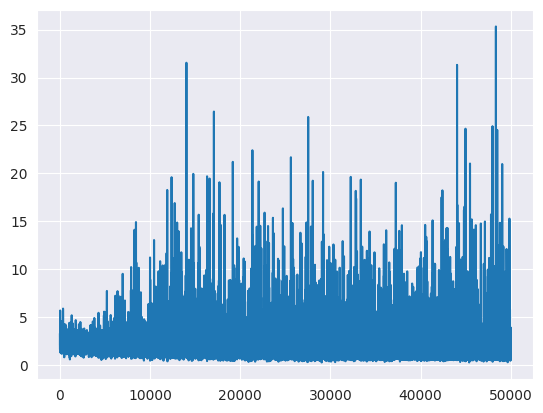

In [14]:
plt.figure()
plt.plot(val_losses)

In [15]:
from datetime import datetime

now = datetime.now()

timestamp = now.strftime("%Y-%m-%d_%H:%M:%S")

In [16]:
name = "./weights/model_34_"+timestamp+".pth"
torch.save(model.state_dict(), name)

In [17]:
import pickle

name = "./results/losses_"+timestamp+".pickle"
with open(name, 'wb') as f:
    pickle.dump(train_losses, f)

In [18]:
name = "./results/val_losses_"+timestamp+".pickle"
with open(name, 'wb') as f:
    pickle.dump(val_losses, f)